# Import Required Libraries
Import the necessary libraries for building and training the GAN model, as well as utilities for data handling and visualization.

In [55]:
import os
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import dill
import warnings
warnings.filterwarnings("ignore", message=".*cudnnException.*")

### Reconstruct Dataset with Neural Network

This script processes masked images from the dataset (`../Dataset`) using a trained neural network and saves the reconstructed images in `./Dataset_Reconstructed`, preserving the original directory structure.


In [56]:
import os
from PIL import Image
import shutil
from Basic_Neural_Network.inference_function_neural_network import run_inference_neural_network
import numpy as np

def create_reconstructed_dataset(activate=False):
    """
    Automatically accesses dataset directories and reconstructs images.
    The model file and dataset paths are fixed based on your structure.

    Args:
        activate (bool): Whether to activate this function.
    """
    if not activate:
        print("Reconstruction function is not activated.")
        return

    # Fixed paths based on your structure
    model_path = os.path.join("..", "saved_models", "Neural_network", "NeuralNetwork_ImageReconstruction.pth")
    base_dir = os.path.join("..", "Dataset")  # Original dataset
    reconstructed_dir = os.path.join(".", "Dataset_Reconstructed")  # Reconstructed dataset at the same level as the code

    # Auto-detect device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Define subdirectories (train, validation, test)
    subdirs = ["train", "validation", "test"]
    for subdir in subdirs:
        src_dir = os.path.join(base_dir, subdir)
        dest_dir = os.path.join(reconstructed_dir, subdir)

        # Check if source directory exists
        if not os.path.exists(src_dir):
            raise FileNotFoundError(f"Source directory not found: {src_dir}")

        # Remove and recreate destination directory
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)
        os.makedirs(dest_dir)

        # Traverse all images in the source directory
        for filename in os.listdir(src_dir):
            if filename.endswith("_masked.jpg"):
                # Load masked image
                masked_path = os.path.join(src_dir, filename)
                masked_image = Image.open(masked_path).convert("RGB")

                # Perform inference
                reconstructed_array = run_inference_neural_network(
                    model_path=model_path,
                    images=[masked_image],
                    grid_size=4,
                    target_size=(224, 224),
                    device=device
                )[0]  # Single image, so take the first result

                # Convert NumPy array to PIL.Image
                reconstructed_image = Image.fromarray(
                    np.clip(reconstructed_array, 0, 255).astype(np.uint8)
                )

                # Save reconstructed image
                original_filename = filename.replace("_masked.jpg", ".jpg")
                save_path = os.path.join(dest_dir, original_filename)
                reconstructed_image.save(save_path)

    print(f"Reconstructed dataset created at '{reconstructed_dir}'.")

# Call the function
create_reconstructed_dataset(
    activate=False  # Activate the function to execute
)


Reconstruction function is not activated.


# Define Dataset Class
We create a custom dataset class to load pairs of original and masked images. The images are assumed to have the same name, with `_masked` appended to the masked image files.

In [57]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageMaskDataset(Dataset):
    """
    Custom Dataset to load original and masked image pairs.
    Assumes original images and masked images have the same name,
    with `_masked` appended to the masked images.
    """
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if not f.endswith("_masked.jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_name = self.image_files[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")

        original_path = os.path.join(self.directory, original_name)
        masked_path = os.path.join(self.directory, masked_name)

        # Load images
        original_img = Image.open(original_path).convert("RGB")
        masked_img = Image.open(masked_path).convert("RGB")

        if self.transform:
            original_img = self.transform(original_img)
            masked_img = self.transform(masked_img)

        return masked_img, original_img

# Define transformations to normalize image pixels to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors (auto-normalized to [0, 1])
])

# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Initialize datasets
train_dataset = ImageMaskDataset(train_dir, transform=transform)
val_dataset = ImageMaskDataset(val_dir, transform=transform)
test_dataset = ImageMaskDataset(test_dir, transform=transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify dataset sizes and loader functionality
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 9440, Validation samples: 1350, Test samples: 2710


# Define the Generator
The generator reconstructs original images from masked images by learning to map the masked inputs to the target distribution.

In [58]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Residual connection

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResidualBlock(128),  # Residual block
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ResidualBlock(256)  # Residual block
        )
        
        # Attention layer
        self.attention = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),  # Reduce dimensions for attention
            nn.Softmax(dim=1)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            ResidualBlock(256),  # Residual block
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        attention_weights = self.attention(encoded)  # Apply attention
        encoded = encoded * attention_weights  # Weighted encoding
        decoded = self.decoder(encoded)
        return decoded

# Instantiate and print
generator = Generator()
print(generator)


Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# Define the Discriminator
The discriminator classifies images as real (original) or fake (generated by the generator). This provides feedback to improve the generator.

In [59]:
class Discriminator(nn.Module):
    """
    Discriminator network to classify real vs. fake images.
    """
    def __init__(self, input_channels=3, image_size=224):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # Downsample to 112x112
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample to 56x56
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample to 28x28
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Downsample to 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # Downsample to 7x7
            nn.LeakyReLU(0.2)
        )
        
        # Compute the output size dynamically
        with torch.no_grad():
            test_input = torch.randn(1, input_channels, image_size, image_size)  # Test input
            conv_out = self.conv(test_input)
            self.flattened_size = conv_out.numel()  # Calculate flattened size
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 1),  # Match the dynamically calculated size
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)  # Pass through convolutional layers
        x = self.model(x)  # Flatten and apply the linear + sigmoid layers
        return x
    
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


# Define Loss Functions and Optimizers
We use Binary Cross-Entropy Loss (BCE) for both the generator and discriminator. Adam optimizers are used for both networks.

In [60]:
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
reconstruction_loss = nn.MSELoss() # 

optimizer_G = optim.Adam(generator.parameters(), lr=0.000001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000001, betas=(0.5, 0.999))

# Validation Function
The `validate` function evaluates the generator on the validation dataset. 
It computes the combined adversarial and reconstruction losses for the generated images.

In [61]:
def validate(generator, val_loader):
    generator.eval()  # Set generator to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for validation
        for masked_imgs, original_imgs in val_loader:
            masked_imgs, original_imgs = masked_imgs.to(device), original_imgs.to(device)

            # Generate images
            gen_imgs = generator(masked_imgs)

            # Compute adversarial loss
            valid = torch.ones((masked_imgs.size(0), 1), device=device)
            adv_loss = adversarial_loss(discriminator(gen_imgs), valid)

            # Compute reconstruction loss
            pixel_loss = reconstruction_loss(gen_imgs, original_imgs)

            # Combine losses
            combined_loss = adv_loss + 10 * pixel_loss
            val_loss += combined_loss.item()

    return val_loss / len(val_loader)  # Average validation loss

# Visualize Generated Images
Compare the masked, generated, and original images to evaluate the GAN's performance.

In [62]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def visualize_reference_images(generator, reference_images_dir, transform, grid_size=5):
    generator.eval()  # Ensure the generator is in evaluation mode

    # Load reference images
    masked_image_files = sorted(os.listdir(reference_images_dir))
    masked_images = []
    for file_name in masked_image_files:
        image_path = os.path.join(reference_images_dir, file_name)
        masked_image = Image.open(image_path).convert("RGB")  # Open image in RGB format
        masked_images.append(transform(masked_image))  # Apply transformations (e.g., ToTensor)

    # Stack into a batch and move to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    masked_images = torch.stack(masked_images).to(device)  # Shape: [batch_size, channels, height, width]

    # Generate reconstructed images
    with torch.no_grad():
        generated_images = generator(masked_images)  # Model output
        generated_images = generated_images.cpu()  # Move to CPU for visualization

    # Visualization with a 5x2 grid
    fig, axs = plt.subplots(2, grid_size, figsize=(15, 8))  # 2 rows, 5 columns for 10 images

    for i, file_name in enumerate(masked_image_files):
        row = i // grid_size  # Calculate row index dynamically
        col = i % grid_size  # Column index within the grid

        # Convert tensors to [height, width, channels] for imshow
        masked_image = (masked_images[i] * 255.0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        reconstructed_image = (generated_images[i] * 255.0).permute(1, 2, 0).numpy().astype(np.uint8)

        # Display masked image in the first row
        axs[0, col].imshow(masked_image)
        axs[0, col].axis("off")
        axs[0, col].set_title(f"Masked {i+1}")

        # Display reconstructed image in the second row
        axs[1, col].imshow(reconstructed_image)
        axs[1, col].axis("off")
        axs[1, col].set_title(f"Reconstructed {i+1}")

        # If it's the last image in a row of 5, finalize the current grid and start a new one
        if (i + 1) % grid_size == 0 or i == len(masked_image_files) - 1:
            plt.tight_layout()
            plt.show()

            # If there are more images, create a new grid
            if i != len(masked_image_files) - 1:
                fig, axs = plt.subplots(2, grid_size, figsize=(15, 8))

    plt.tight_layout()
    plt.show()


# Training Loop
The GAN is trained by alternately updating the generator and discriminator. The generator tries to fool the discriminator, while the discriminator tries to correctly classify real and fake images.

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

def train_gan(epochs, pretrain_epochs=1):
    history = {"g_loss": [], "d_loss": [], "val_g_loss": []}

    # Define loss functions
    mse_loss = torch.nn.MSELoss()
    mae_loss = torch.nn.L1Loss()

    # Pretrain the generator
    print("Pretraining the Generator...")
    for epoch in range(pretrain_epochs):
        generator.train()  # Ensure the generator is in training mode
        for masked_image, original_image in train_loader:  # Assuming `train_loader` is defined
            masked_image, original_image = masked_image.to(device), original_image.to(device)

            optimizer_G.zero_grad()

            # Forward pass: Generator
            generated_image = generator(masked_image)

            # Compute reconstruction loss (MSE + MAE)
            loss = mse_loss(generated_image, original_image) + mae_loss(generated_image, original_image)

            # Backpropagation and optimization
            loss.backward()
            optimizer_G.step()

        print(f"Pretrain Epoch {epoch+1}/{pretrain_epochs}, Reconstruction Loss: {loss.item():.4f}")

    print("Pretraining complete. Starting adversarial training...")

    # Adversarial training
    for epoch in range(epochs):
        generator.train()  # Ensure the generator is in training mode
        discriminator.train()  # Ensure the discriminator is in training mode

        for masked_image, original_image in train_loader:
            masked_image, original_image = masked_image.to(device), original_image.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = discriminator(original_image)
            fake_output = discriminator(generator(masked_image).detach())

            real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
            fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
            discriminator_loss = real_loss + fake_loss
            discriminator_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            generated_image = generator(masked_image)
            adversarial_loss_gen = adversarial_loss(discriminator(generated_image), torch.ones_like(real_output))
            reconstruction_loss = mse_loss(generated_image, original_image) + mae_loss(generated_image, original_image)

            total_generator_loss = 0.5 * reconstruction_loss + 0.5 * adversarial_loss_gen
            total_generator_loss.backward()
            optimizer_G.step()

        # Logging training losses
        history["g_loss"].append(total_generator_loss.item())
        history["d_loss"].append(discriminator_loss.item())

        # Validation Phase
        generator.eval()  # Set generator to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for masked_image, original_image in val_loader:  # Assuming `val_loader` is defined
                masked_image, original_image = masked_image.to(device), original_image.to(device)

                generated_image = generator(masked_image)
                val_loss += mse_loss(generated_image, original_image).item() + mae_loss(generated_image, original_image).item()

        val_loss /= len(val_loader)  # Average validation loss
        history["val_g_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, G Loss: {total_generator_loss.item():.4f}, D Loss: {discriminator_loss.item():.4f}, Val Loss: {val_loss:.4f}")

    return history


# Train the GAN
Train the GAN using the training dataset for a specified number of epochs.

In [64]:
history = train_gan(epochs=100, pretrain_epochs=500)

Pretraining the Generator...
Pretrain Epoch 1/500, Reconstruction Loss: 0.1842
Pretrain Epoch 2/500, Reconstruction Loss: 0.1296
Pretrain Epoch 3/500, Reconstruction Loss: 0.1199
Pretrain Epoch 4/500, Reconstruction Loss: 0.1201
Pretrain Epoch 5/500, Reconstruction Loss: 0.1002
Pretrain Epoch 6/500, Reconstruction Loss: 0.0894
Pretrain Epoch 7/500, Reconstruction Loss: 0.0887
Pretrain Epoch 8/500, Reconstruction Loss: 0.0894
Pretrain Epoch 9/500, Reconstruction Loss: 0.1048
Pretrain Epoch 10/500, Reconstruction Loss: 0.0927
Pretrain Epoch 11/500, Reconstruction Loss: 0.1061
Pretrain Epoch 12/500, Reconstruction Loss: 0.0933
Pretrain Epoch 13/500, Reconstruction Loss: 0.0873
Pretrain Epoch 14/500, Reconstruction Loss: 0.0939
Pretrain Epoch 15/500, Reconstruction Loss: 0.0973
Pretrain Epoch 16/500, Reconstruction Loss: 0.0832
Pretrain Epoch 17/500, Reconstruction Loss: 0.0772
Pretrain Epoch 18/500, Reconstruction Loss: 0.0652
Pretrain Epoch 19/500, Reconstruction Loss: 0.0563
Pretrain Ep

# Plot Training and Validation Losses
This function plots the generator's training and validation losses (`g_loss` and `val_g_loss`), as well as the discriminator's loss (`d_loss`). Validation loss is plotted with a dashed line for better distinction.

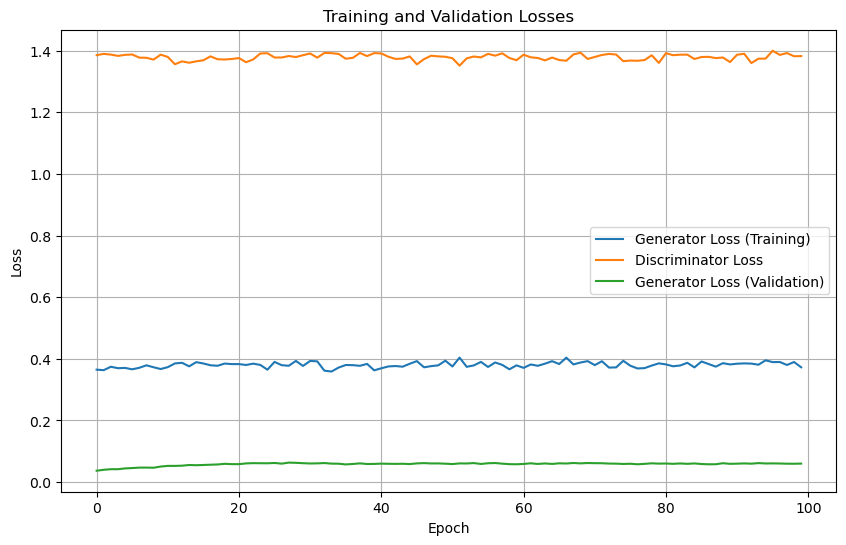

In [65]:
def plot_losses(history):
    
    plt.figure(figsize=(10, 6))
    # Plot generator loss (training)
    plt.plot(history["g_loss"], label="Generator Loss (Training)")
    
    # Plot discriminator loss
    plt.plot(history["d_loss"], label="Discriminator Loss")
    
    # Plot validation generator loss
    plt.plot(history["val_g_loss"], label="Generator Loss (Validation)")
    
    # Add labels, title, and legend
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
plot_losses(history)

## Evaluation of GAN on Test Set
This section evaluates the GAN's generator on the test set, computing the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** for the generated images compared to the originals.


In [66]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lists to store MSE and MAE for each image
mse_list = []
mae_list = []

# Evaluate on the test set
print("Evaluating the GAN on the test set...")
with torch.no_grad():
    for masked_images, original_images in test_loader:
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)

        # Generate reconstructed images
        generated_images = generator(masked_images)

        # Un-normalize images to [0, 255] and convert to numpy arrays
        unnormalized_generated_images = (generated_images * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)
        unnormalized_original_images = (original_images * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)

        # Flatten and compute MSE/MAE for each pair of images
        for reconstructed, original in zip(unnormalized_generated_images, unnormalized_original_images):
            mse_list.append(mean_squared_error(original.flatten(), reconstructed.flatten()))
            mae_list.append(mean_absolute_error(original.flatten(), reconstructed.flatten()))

# Calculate average MSE and MAE
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)

# Print final results
print(f"Test Results - Average MSE: {average_mse:.2f}")
print(f"Test Results - Average MAE: {average_mae:.2f}")


Evaluating the GAN on the test set...
Test Results - Average MSE: 67.73
Test Results - Average MAE: 133.89


# Test Set Visualization
Display masked, generated, and original images from the test set.

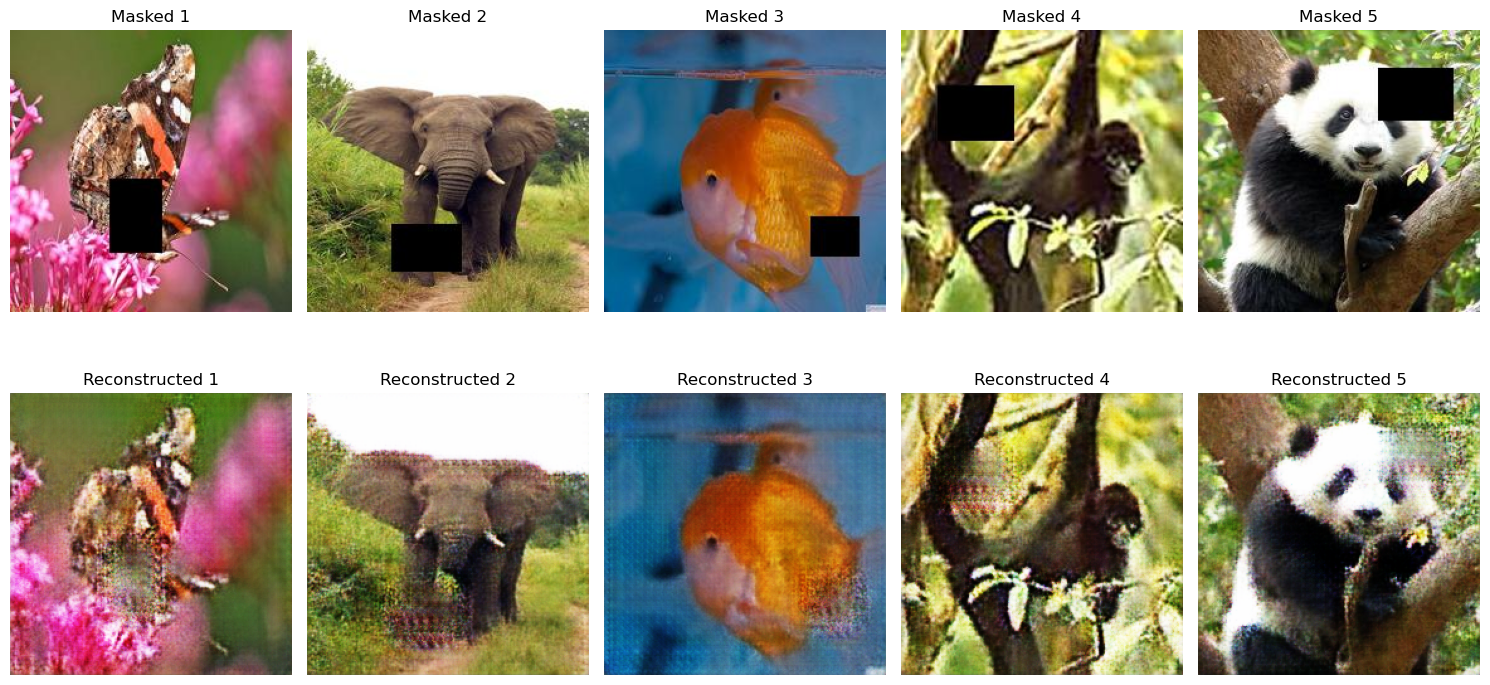

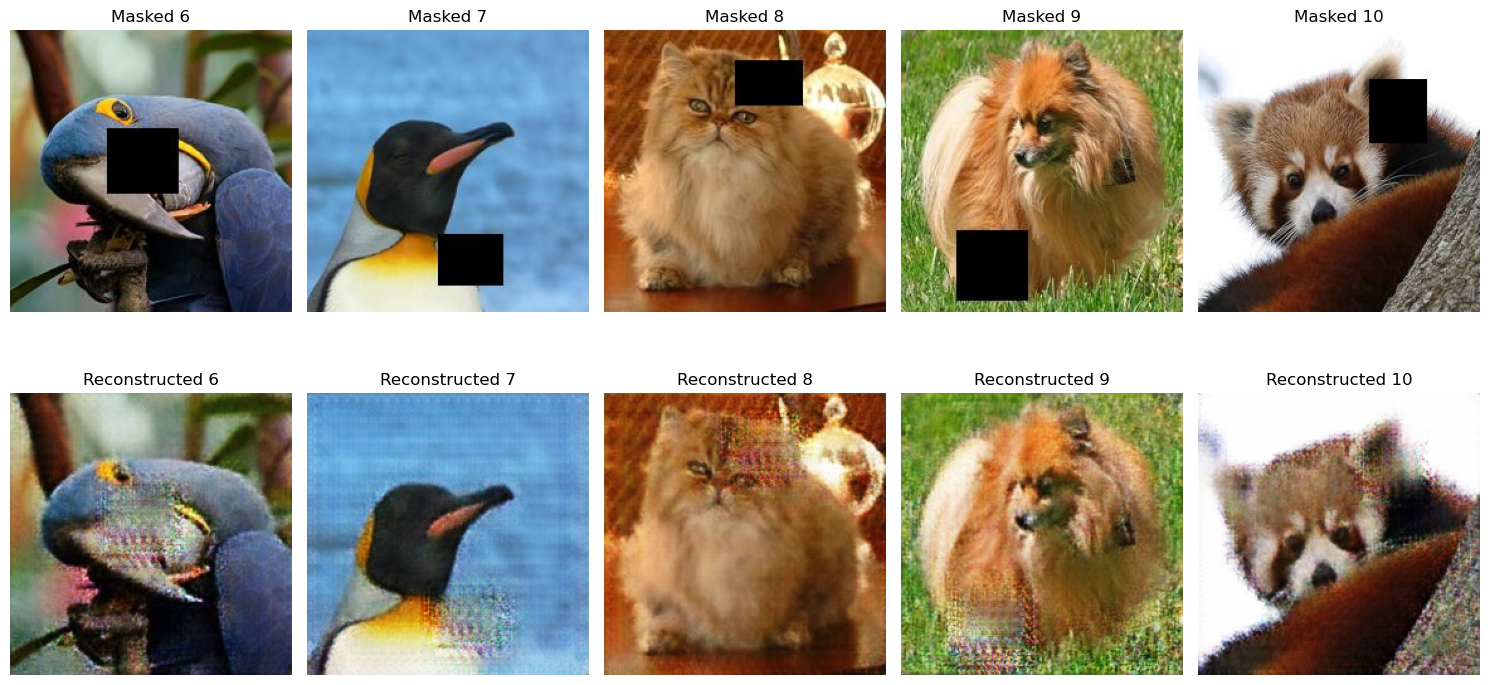

<Figure size 640x480 with 0 Axes>

In [67]:
# Path to referance images
reference_images_dir = os.path.join("..", "Reference_Images")

# Visualize a few images of the train set
visualize_reference_images(generator, reference_images_dir, transform)

# Save Trained Models
Save the trained generator and discriminator models to a specified directory for later validation or reuse.

In [68]:
import os
import torch
import dill

# Parent directory for saving models, moved one level deeper
parent_dir = os.path.join("..", "saved_models", "GanModels")

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Define the name and path for the subdirectory
sub_dir_name = "Small_training_testing"
sub_dir_path = os.path.join(parent_dir, sub_dir_name)

# Create the subdirectory if it doesn't exist
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)

# Define file paths for saving generator and discriminator models
generator_path = os.path.join(sub_dir_path, "generator_full.pth")
discriminator_path = os.path.join(sub_dir_path, "discriminator_full.pth")

# Save the full models using dill as the pickle module
torch.save(generator, generator_path, pickle_module=dill)
torch.save(discriminator, discriminator_path, pickle_module=dill)

# Inform the user of the save locations
print(f"Full Generator model saved to: {generator_path}")
print(f"Full Discriminator model saved to: {discriminator_path}")

Full Generator model saved to: ..\saved_models\GanModels\Small_training_testing\generator_full.pth
Full Discriminator model saved to: ..\saved_models\GanModels\Small_training_testing\discriminator_full.pth
